# Baseline model for batch monitoring example

In [1]:
import requests
import datetime
import pandas as pd

from evidently import ColumnMapping
from evidently.report import Report
from evidently.metrics import ColumnDriftMetric, DatasetDriftMetric, DatasetMissingValuesMetric, ColumnQuantileMetric

from joblib import load, dump
from tqdm import tqdm

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [3]:
files = [('green_tripdata_2023-03.parquet', './data'), ('green_tripdata_2023-02.parquet', './data')]

print("Download files:")
for file, path in files:
    url=f"https://d37ci6vzurychx.cloudfront.net/trip-data/{file}"
    resp=requests.get(url, stream=True)
    save_path=f"{path}/{file}"
    with open(save_path, "wb") as handle:
        for data in tqdm(resp.iter_content(),
                        desc=f"Downloading {file}",
                        postfix=f"saved to {save_path}",
                        total=int(resp.headers["Content-Length"])):
            handle.write(data)

Download files:


In [5]:
march_data = pd.read_parquet('data/green_tripdata_2023-03.parquet')

In [7]:
march_data.describe()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
count,72044.000000,72044,72044,67507.000000,72044.000000,72044.000000,67507.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,72044.000000,0.0,72044.000000,72044.000000,67507.000000,67500.000000,67507.000000
mean,1.865443,2023-03-16 08:02:42.689842432,2023-03-16 08:20:56.525747968,1.145703,98.437413,137.613556,1.286844,12.449511,17.018203,0.878109,0.576929,2.157651,0.183268,NaN,0.961604,22.292310,1.373680,1.028681,0.714837
min,1.000000,2023-02-23 16:46:29,2023-02-23 16:55:25,1.000000,1.000000,1.000000,0.000000,0.000000,-115.000000,-5.000000,-0.500000,-1.100000,0.000000,NaN,-1.000000,-116.000000,1.000000,1.000000,-2.750000
25%,2.000000,2023-03-08 13:55:49.500000,2023-03-08 14:15:59.750000128,1.000000,74.000000,74.000000,1.000000,1.100000,9.300000,0.000000,0.500000,0.000000,0.000000,NaN,1.000000,12.980000,1.000000,1.000000,0.000000
50%,2.000000,2023-03-16 08:05:27.500000,2023-03-16 08:22:27,1.000000,75.000000,138.000000,1.000000,1.840000,13.500000,0.000000,0.500000,1.600000,0.000000,NaN,1.000000,18.100000,1.000000,1.000000,0.000000
75%,2.000000,2023-03-23 21:51:25.500000,2023-03-23 22:12:31.500000,1.000000,129.000000,216.000000,1.000000,3.300000,20.000000,1.000000,0.500000,3.360000,0.000000,NaN,1.000000,26.730000,2.000000,1.000000,2.750000
max,2.000000,2023-04-01 00:09:27,2023-04-01 17:32:21,99.000000,265.000000,265.000000,9.000000,92064.680000,477.000000,12.500000,4.250000,270.270000,36.050000,NaN,1.000000,478.000000,5.000000,2.000000,2.750000
std,0.341252,NaN,NaN,1.225735,60.481870,76.169705,0.923652,641.094653,13.832399,1.297642,0.384129,3.136215,1.139159,NaN,0.185185,15.852047,0.512307,0.166911,1.206435


In [8]:
march_data.shape

(72044, 20)

In [9]:
# create target
march_data["duration_min"] = march_data.lpep_dropoff_datetime - march_data.lpep_pickup_datetime
march_data.duration_min = march_data.duration_min.apply(lambda td : float(td.total_seconds())/60)

In [10]:
# filter out outliers
march_data = march_data[(march_data.duration_min >= 0) & (march_data.duration_min <= 60)]
march_data = march_data[(march_data.passenger_count > 0) & (march_data.passenger_count <= 8)]

<Axes: >

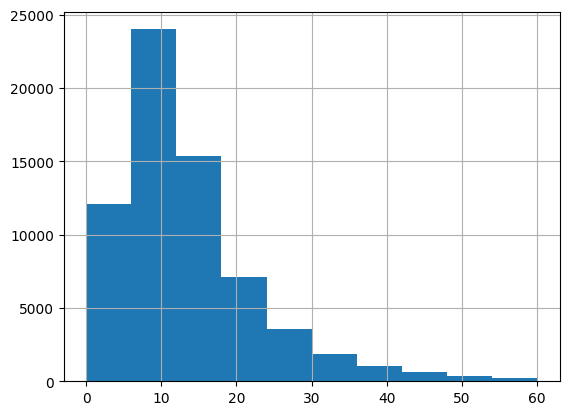

In [11]:
march_data.duration_min.hist()

In [12]:
# data labeling
target = "duration_min"
num_features = ["passenger_count", "trip_distance", "fare_amount", "total_amount"]
cat_features = ["PULocationID", "DOLocationID"]

In [13]:
march_data.shape

(66255, 21)

In [14]:
train_data = march_data[:30000]
val_data = march_data[30000:]

In [15]:
val_data

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge,duration_min
30570,1,2023-03-14 18:42:08,2023-03-14 18:49:51,N,1.0,74,75,1.0,1.30,9.3,2.5,1.5,1.26,0.0,NaN,1.0,14.56,1.0,1.0,0.00,7.716667
30571,1,2023-03-14 18:08:00,2023-03-14 18:23:16,N,1.0,244,151,1.0,3.80,19.1,2.5,1.5,0.00,0.0,NaN,1.0,23.10,2.0,1.0,0.00,15.266667
30572,2,2023-03-14 18:44:02,2023-03-14 18:53:17,N,1.0,65,97,2.0,1.17,10.7,2.5,0.5,2.94,0.0,NaN,1.0,17.64,1.0,1.0,0.00,9.250000
30573,2,2023-03-14 18:21:43,2023-03-14 18:28:15,N,1.0,41,74,1.0,0.79,7.9,2.5,0.5,5.00,0.0,NaN,1.0,16.90,1.0,1.0,0.00,6.533333
30574,2,2023-03-14 18:19:19,2023-03-14 18:44:35,N,1.0,75,233,1.0,3.24,24.0,2.5,0.5,2.00,0.0,NaN,1.0,32.75,1.0,1.0,2.75,25.266667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67502,2,2023-03-31 23:50:25,2023-04-01 00:16:45,N,1.0,247,243,1.0,4.22,26.1,1.0,0.5,0.00,0.0,NaN,1.0,28.60,2.0,1.0,0.00,26.333333
67503,2,2023-03-31 23:48:18,2023-03-31 23:55:30,N,1.0,33,54,1.0,1.08,8.6,1.0,0.5,2.00,0.0,NaN,1.0,13.10,1.0,1.0,0.00,7.200000
67504,2,2023-03-31 23:51:40,2023-03-31 23:59:21,N,1.0,74,41,1.0,1.37,10.0,1.0,0.5,2.00,0.0,NaN,1.0,14.50,1.0,1.0,0.00,7.683333
67505,2,2023-03-31 23:26:43,2023-03-31 23:38:51,N,1.0,95,121,1.0,2.58,15.6,1.0,0.5,0.00,0.0,NaN,1.0,18.10,1.0,1.0,0.00,12.133333


In [16]:
model = LinearRegression()

In [17]:
model.fit(train_data[num_features + cat_features], train_data[target])

LinearRegression()

In [18]:
train_preds = model.predict(train_data[num_features + cat_features])
train_data['prediction'] = train_preds

In [19]:
val_preds = model.predict(val_data[num_features + cat_features])
val_data['prediction'] = val_preds

In [20]:
print(mean_absolute_error(train_data.duration_min, train_data.prediction))
print(mean_absolute_error(val_data.duration_min, val_data.prediction))

3.5641759571064897
3.646951695051197


# Dump model and reference data

In [21]:
with open('model/lin_reg.bin', 'wb') as f_out:
    dump(model, f_out)

In [22]:
val_data.to_parquet('data/reference.parquet')

# Evidently Report

In [23]:
column_mapping = ColumnMapping(
    target=None,
    prediction='prediction',
    numerical_features=num_features,
    categorical_features=cat_features
)

In [25]:
report = Report(metrics=[
    ColumnDriftMetric(column_name='prediction'),
    ColumnQuantileMetric(column_name="fare_amount", quantile=0.5),
    DatasetDriftMetric(),
    DatasetMissingValuesMetric()
]
)

In [26]:
report.run(reference_data=train_data, current_data=val_data, column_mapping=column_mapping)

In [27]:
report.show(mode='inline')

In [28]:
result = report.as_dict()

In [29]:
result

{'metrics': [{'metric': 'ColumnDriftMetric',
   'result': {'column_name': 'prediction',
    'column_type': 'num',
    'stattest_name': 'Wasserstein distance (normed)',
    'stattest_threshold': 0.1,
    'drift_score': 0.021912744737353416,
    'drift_detected': False,
    'current': {'small_distribution': {'x': [-29.976938687069897,
       -6.360433663687498,
       17.2560713596949,
       40.872576383077295,
       64.48908140645969,
       88.1055864298421,
       111.7220914532245,
       135.3385964766069,
       158.9551014999893,
       182.57160652337168,
       206.1881115467541],
      'y': [9.343432451141244e-06,
       0.034430548582455485,
       0.00751562347788674,
       0.0003457070006922261,
       2.3358581127853093e-05,
       8.175503394748592e-06,
       5.839645281963273e-06,
       1.1679290563926561e-06,
       2.3358581127853122e-06,
       1.1679290563926546e-06]}},
    'reference': {'small_distribution': {'x': [-44.79458026994583,
       -20.705700872911166,

In [33]:
#prediction drift
result['metrics'][0]['result']['drift_score']

0.021912744737353416

In [35]:

result['metrics'][1]['result']["reference"]["value"]

12.8

In [38]:
#number of drifted columns
result['metrics'][2]['result']["number_of_columns"]

7

In [42]:
# ahare of missing values
result['metrics'][3]['result']["current"]["share_of_missing_values"]

0.0454570529456752